In [71]:
import pandas as pd 
import pandas_profiling as pdp
import numpy as np

from sklearn.experimental import enable_iterative_imputer # Enable experimental IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_score, plot_confusion_matrix, plot_roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier

from yellowbrick.model_selection import learning_curve

import warnings

In [72]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv") # The samples we need predictions for

In [73]:
pdp.ProfileReport(data_train)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [74]:
data_train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
data_test.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)
passenger_id_col = data_test.pop("PassengerId")
data_train.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

In [75]:
# Convert categorical data to dummy variables (integers) and drop first column as they will be perfectly inversely correlated.
data_train = pd.get_dummies(data_train, drop_first=True)
data_test = pd.get_dummies(data_test, drop_first=True)
data_train.head()

Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500         1           0   
1         1       1  38.0      1      0  71.2833         0           0   
2         1       3  26.0      0      0   7.9250         0           0   
3         1       1  35.0      1      0  53.1000         0           0   
4         0       3  35.0      0      0   8.0500         1           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1

In [76]:
y_train = data_train.pop("Survived")
X_train = data_train.copy()

In [77]:
X_train.isnull().sum()

Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_male        0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [78]:
data_test.isnull().sum()

Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_male       0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [79]:
imputer = IterativeImputer()
X_train["Age"] = imputer.fit_transform(X_train[["Age"]]).ravel()
data_test[["Age", "Fare"]] = imputer.fit_transform(data_test[["Age", "Fare"]])
X_train.head()

Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S
0       3  22.0      1      0   7.2500         1           0           1
1       1  38.0      1      0  71.2833         0           0           0
2       3  26.0      0      0   7.9250         0           0           1
3       1  35.0      1      0  53.1000         0           0           1
4       3  35.0      0      0   8.0500         1           0           1

In [80]:
# Scale values of non-binary features to same range
scaler = StandardScaler()
X_train[["Pclass", "Age", "SibSp", "Parch", "Fare"]] = scaler.fit_transform(X_train[["Pclass", "Age", "SibSp", "Parch", "Fare"]])
data_test[["Pclass", "Age", "SibSp", "Parch", "Fare"]] = scaler.fit_transform(data_test[["Pclass", "Age", "SibSp", "Parch", "Fare"]])
X_train.head()

Pclass       Age     SibSp     Parch      Fare  Sex_male  Embarked_Q  \
0  0.827377 -0.592481  0.432793 -0.473674 -0.502445         1           0   
1 -1.566107  0.638789  0.432793 -0.473674  0.786845         0           0   
2  0.827377 -0.284663 -0.474545 -0.473674 -0.488854         0           0   
3 -1.566107  0.407926  0.432793 -0.473674  0.420730         0           0   
4  0.827377  0.407926 -0.474545 -0.473674 -0.486337         1           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1

In [81]:
# Split the final training data in to a testing set for evaluating performance before final submission
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [82]:
# Baseline Model to compare our results to
dc = DummyClassifier()
dc.fit(X_train_s, y_train_s)
print(f"""Baseline Model
Accuracy: {dc.score(X_test_s, y_test_s)}""")

Baseline Model
Accuracy: 0.600896860986547


In [83]:
# Hyperparameter tuning

warnings.filterwarnings("ignore") # Temporarily ignore any parameter incompatibility warnings

lr_param_grid = {
    "penalty" : ["l1", "l2", "elasticnet", "none"],
    "C" : np.arange(0.1, 100.0, 2.0),
    "fit_intercept" : [True, False],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter" : np.arange(50, 1000, 50),
}

dtc_param_grid = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_depth" : list(np.arange(2, 30, 2)) + [None],
    "min_samples_split" : np.arange(2, 10, 2),
    "min_samples_leaf" : np.arange(1, 10, 1),
    "max_features" : ["sqrt", "log2", None]
}

knc_param_grid = {
    "n_neighbors" : np.arange(1, 100, 2),
    "weights" : ["uniform", "distance"],
    "metric" : ["euclidean", "manhattan", "chebyshev", "minkowski", "seuclidean"]
}

gnb_param_grid = {
    "var_smoothing" : np.arange(0.0000000005, 0.000000100, 0.000000001),
}

svc_param_grid = {
    "C" : np.arange(0.1, 100.0, 2.0),
    "kernel" : ["linear", "poly", "rbf", "sigmoid"]
}

rfc_param_grid = {
    "n_estimators" : np.arange(50, 1000, 50),
    "criterion" : ["gini", "entropy"],
    "max_depth" : list(np.arange(2, 30, 2)) + [None],
    "min_samples_split" : np.arange(2, 20, 2),
    "min_samples_leaf" : np.arange(1, 10, 1),
    "max_features" : ["sqrt", "log2", None]
}

xgbc_param_grid = {
    "n_estimators" : np.arange(50, 1000, 50),
    "max_depth" : list(np.arange(2, 30, 2)) + [None],
    "learning_rate" : np.arange(0.01, 10, 0.5),
    "booster" : ["gbtree", "gblinear", "dart"],
    "eval_metric" : ["error"],
    "n_jobs" : [-1]
}

ada_param_grid = {
    "n_estimators" : np.arange(50, 500, 50),
    "learning_rate" : np.arange(0.5, 5, 0.5)
}

clf_lists = [[LogisticRegression, lr_param_grid, None], 
             [DecisionTreeClassifier, dtc_param_grid, None], 
             [KNeighborsClassifier, knc_param_grid, None], 
             [GaussianNB, gnb_param_grid, None], 
             [SVC, svc_param_grid, None], 
             [RandomForestClassifier, rfc_param_grid, None],
             [XGBClassifier, xgbc_param_grid, None],
             [AdaBoostClassifier, ada_param_grid, None]] # Estimator, parameters, best parameters
for c in clf_lists:
    clf_instance = c[0]()
    iterations = 250
    if c[0] is RandomForestClassifier:
        iterations = 100
    elif c[0] is XGBClassifier:
        iterations = 5
    print(iterations)
    random_search = RandomizedSearchCV(clf_instance, param_distributions=c[1], n_iter=iterations, n_jobs=-1)
    random_search.fit(X_train, y_train)
    print(f"""Model: {type(clf_instance).__name__}
Best parameters:
{random_search.best_params_}""")
    c[2] = random_search.best_params_

250
Model: LogisticRegression
Best parameters:
{'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 500, 'fit_intercept': False, 'C': 12.1}
250
Model: DecisionTreeClassifier
Best parameters:
{'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 6, 'criterion': 'gini'}
250
Model: KNeighborsClassifier
Best parameters:
{'weights': 'uniform', 'n_neighbors': 15, 'metric': 'manhattan'}
250
Model: GaussianNB
Best parameters:
{'var_smoothing': 5e-10}
250
Model: SVC
Best parameters:
{'kernel': 'rbf', 'C': 2.1}
100
Model: RandomForestClassifier
Best parameters:
{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 28, 'criterion': 'gini'}
5
Model: XGBClassifier
Best parameters:
{'n_jobs': -1, 'n_estimators': 800, 'max_depth': 6, 'learning_rate': 6.01, 'eval_metric': 'error', 'booster': 'gbtree'}
250
Model: AdaBoostClassifier
Best parameters:
{'n_estimators': 150, 'learning_rate': 1.5}


In [84]:
warnings.filterwarnings("ignore") # Temporarily ignore any parameter incompatibility warnings

lr = LogisticRegression(**clf_lists[0][2])
dtc = DecisionTreeClassifier(**clf_lists[1][2])
knc = KNeighborsClassifier(**clf_lists[2][2])
gnb = GaussianNB(**clf_lists[3][2])
svc = SVC(**clf_lists[4][2])
rfc = RandomForestClassifier(**clf_lists[5][2])
xgbc = XGBClassifier(**clf_lists[6][2])
ada = AdaBoostClassifier(**clf_lists[7][2])

clfs = [lr, 
        dtc, 
        knc, 
        gnb, 
        svc, 
        rfc, 
        xgbc,
        ada,
        StackingClassifier] # List of classifiers to be scored and used for stacking
highest_score = 0
highest_model = lr
for clf in clfs:
    if clf is StackingClassifier:
        est_tuples = [(type(x).__name__, x) for x in clfs[1:-1]] # Name of the estimators and the objects
        model = StackingClassifier(estimators=est_tuples, final_estimator=highest_model)
    else:
        model = clf
    scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=KFold(n_splits=10, shuffle=True, random_state=42))
    print(f"""{model.__class__.__name__}
    AUC: {scores.mean():.4f}
    STD: {scores.std():.3f}""")
    if scores.mean() > highest_score:
        highest_model = model
        highest_score = scores.mean()

LogisticRegression
    AUC: 0.8388
    STD: 0.055
DecisionTreeClassifier
    AUC: 0.8517
    STD: 0.045
KNeighborsClassifier
    AUC: 0.8534
    STD: 0.043
GaussianNB
    AUC: 0.8329
    STD: 0.063
SVC
    AUC: 0.8402
    STD: 0.040
RandomForestClassifier
    AUC: 0.8758
    STD: 0.044
XGBClassifier
    AUC: 0.6641
    STD: 0.115
AdaBoostClassifier
    AUC: 0.8440
    STD: 0.040
StackingClassifier
    AUC: 0.8546
    STD: 0.038


In [85]:
knc_final = KNeighborsClassifier(**clf_lists[2][2])
svc_final = SVC(**clf_lists[4][2])
rfc_final = RandomForestClassifier(**clf_lists[5][2])
xgbc_final = XGBClassifier(**clf_lists[6][2])
ada_final = AdaBoostClassifier(**clf_lists[7][2])

clf_list_final = [knc_final, svc_final, rfc_final, xgbc_final, ada_final]
for i, clf in enumerate(clf_list_final):
    clf.fit(X_train, y_train)
    clf_list_final[i] = (type(clf).__name__, clf)
clf_final = StackingClassifier(estimators=clf_list_final)
_ = clf_final.fit(X_train_s, y_train_s) # Fit final estimator with split training data first

In [86]:
score = clf_final.score(X_test_s, y_test_s)
precision = precision_score(y_test_s, clf_final.predict(X_test_s))
print(f"""Final Classifier
Score: {score}
Precision: {precision}""")

Final Classifier
Score: 0.8071748878923767
Precision: 0.7948717948717948


In [87]:
print("Feature importance per column")
for column, value in sorted(zip(X_train.columns, rfc_final.feature_importances_), key=lambda x: x[1], reverse=True):
    print(f"{column}: {value}")

Feature importance per column
Sex_male: 0.4382999265538725
Fare: 0.19093675438536578
Age: 0.162482029716626
Pclass: 0.13672537401964033
SibSp: 0.039566650557469975
Embarked_S: 0.019003236113419582
Parch: 0.008386096575131114
Embarked_Q: 0.00459993207847481


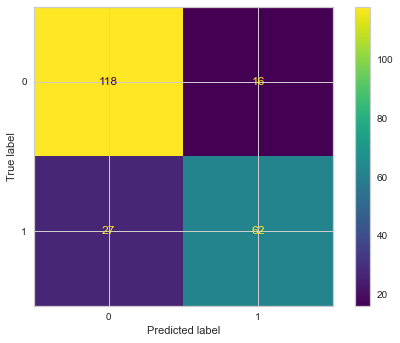

In [88]:
plot_confusion_matrix(clf_final, X_test_s, y_test_s)

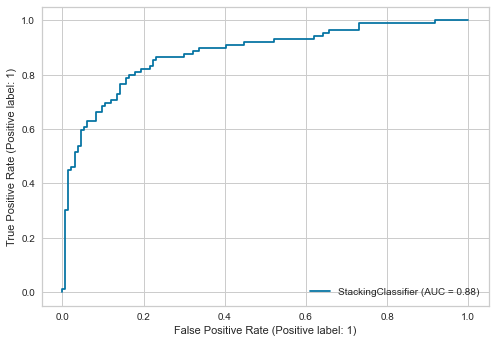

In [89]:
plot_roc_curve(clf_final, X_test_s, y_test_s)

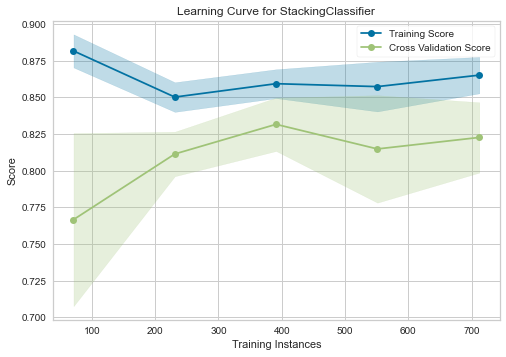

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [90]:
print(learning_curve(clf_final, X_train, y_train))

In [92]:
_ = clf_final.fit(X_train, y_train) # Fit the whole training data, after testing

In [94]:
prediction = clf_final.predict(data_test)
data = { "PassengerId" : passenger_id_col, "Survived": prediction }
result = pd.DataFrame(data)
result.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [96]:
result.to_csv("result.csv", index=False)